In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import sncosmo
import tables
from astropy.time import Time

# Light curve plot

## Data sources:
 1. P48/CFH12K
 2. P60/SEDm
 3. LCOGT-1m/Sinistro
 4. Swift/UVOT
 
## Filter data:
 1. CFH12K: _g_ and _R_
 2. SEDm: _g_, _r_ and _i_
 
## Data filename:
 ```iPTF16abc.h5```

In [6]:
# load light curve data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table = h5file.root.photometry

lc = {"P48/CFH12K": dict(), "P60/SEDm": dict(), "LCOGT_1m/Sinistro": dict(), "Swift/UVOT": dict()}
for filter_name in ["g", "R"]:
    lc["P48/CFH12K"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'P48') & (filter_name == b'%s') & (mag_err < 10)" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name in ["g", "r", "i"]:
    lc["P60/SEDm"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'P60') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name in ["B", "V", "g", "r", "i"]:
    lc["LCOGT_1m/Sinistro"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'LCOGT-1m') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
for filter_name in ["UVW2", "UVM2", "UVW1", "U", "B", "V"]:
    lc["Swift/UVOT"][filter_name] =\
        np.array([(row["time"], row["mag"], row["mag_err"])
                  for row in table.where(
                      "(telescope == b'Swift') & (filter_name == b'%s')" % filter_name)],
                 dtype=[("time", "f"), ("mag", "f"), ("mag_err", "f")])
        
spec_epochs = [t.attrs.OBS_DATE for t in h5file.root.spectroscopy]
    
        
h5file.close()

In [7]:
T_MAX = 57499.65

colors = {"UVW2": "black",
          "UVM2": "Purple",
          "UVW1": "Cyan",
          "U": "DarkBlue",
          "B": "Blue",
          "V": "SkyBlue", 
          "g": "Green",
          "R": "Red", 
          "r": "Red",
          "i": "Yellow"}
markers = {"Swift": "s", 
           "P48": "o",
           "P60": "d",
           "LCOGT_1m": "*"}
offsets = {"UVW2": 6,
           "UVM2": 4,
           "UVW1": 4,
           "U": 3,
           "B": 2,
           "V": 1,
           "g": 0,
           "R": -1,
           "r": -1,
           "i": -3}

In [10]:
# sncosmo
# run sncosmo
# filter data
fp = tables.open_file("filters.h5", mode="r")
filters = dict()
for filter_name in ["g", "R"]:
    filters["P48_" + filter_name] =\
        np.array([(row["wavelength"], row["transmission"])
                  for row in fp.root.P48.CFH12K._f_get_child(filter_name)],
                 dtype=[("wavelength", "f"), ("transmission", "f")])
for filter_name in ["g", "r", "i"]:
    filters["P60_" + filter_name] =\
        np.array([(row["wavelength"], row["transmission"])
                  for row in fp.root.P60.SEDm._f_get_child(filter_name)],
                 dtype=[("wavelength", "f"), ("transmission", "f")])
for key in filters:
    band = sncosmo.Bandpass(filters[key]["wavelength"],
                            filters[key]["transmission"],
                            name=key)
    sncosmo.registry.register(band)
fp.close()

# sncosmo model
dust = sncosmo.F99Dust()
host_dust = sncosmo.F99Dust()
model = sncosmo.Model(source="salt2",
                      effects=[host_dust, dust],
                      effect_names=["host", "mw"],
                      effect_frames=["rest", "obs"])
model.set(z=0.0232)
model.set(t0=T_MAX)
model.set(hostebv=0.332)
model.set(mwebv=0.024)
model.set(x0=0.0275432)
model.set(x1=1.20051)
model.set(c=-0.335264)

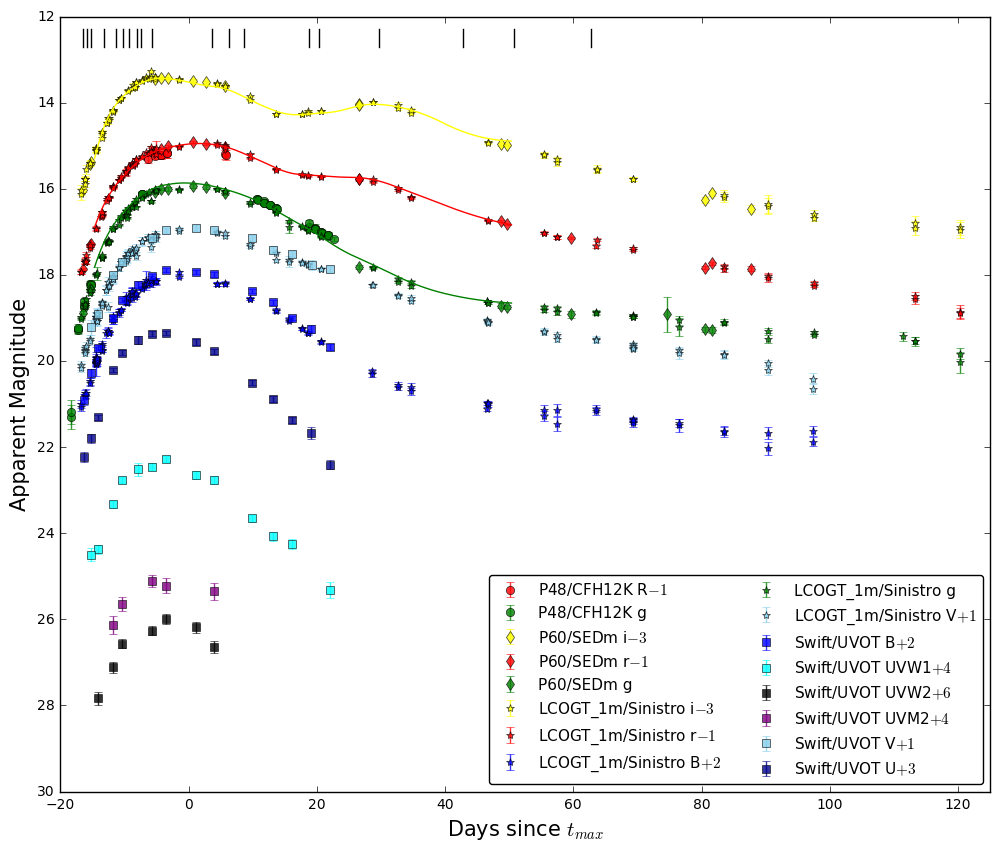

In [13]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)
for tel_inst in lc:
    for filter_name in lc[tel_inst]:
        tel = tel_inst.split("/")[0]
        inst = tel_inst.split("/")[1]
        curve = lc[tel_inst][filter_name]
        ax.errorbar(curve["time"] - T_MAX, 
                    curve["mag"] + offsets[filter_name],
                    yerr=curve["mag_err"], 
                    marker=markers[tel],
                    color=colors[filter_name],
                    linestyle='none',
                    alpha=0.8,
                    label="%s %s" % (tel_inst, filter_name) + ("$%+i$" % offsets[filter_name] if filter_name != "g" else ""))
t = np.linspace(57485, 57550, 300)
for filter_name in ["g", "r", "i"]:
    ax.plot(t - T_MAX, 
            model.bandmag("P60_" + filter_name, "ab", t) + offsets[filter_name], 
            linestyle='-', 
            color=colors[filter_name])

for epoch in spec_epochs:
    t = epoch - T_MAX
    plt.plot([t, t], [12.3, 12.7], color='k', linewidth=1)
        
ax.set_ylim(30, 12)
ax.set_xlabel("Days since $t_{max}$", fontsize=15)
ax.set_ylabel("Apparent Magnitude", fontsize=15)
ax.set_xlim(-20, 125)
ax.legend(loc="lower right", numpoints=1, ncol=2, prop={'size':11}, fancybox=True)
plt.savefig("lightcurve.pdf")

# Spectra data

## Data sources:
 1. Gemini-N GMOS
 2. DCT DeVeny
 3. LCOGT-2m FLOYDS
 4. Keck-II DEIMOS
 5. Keck-I LRIS
 6. NOT ALFOSC
 7. High-resolution data will be presented in a separate figure

In [15]:
class Spectroscopy(object):
    
    def __init__(self, MJD, telescope, instrument, data):
        self.MJD = MJD
        self.telescope = telescope
        self.instrument = instrument
        self.data = data
        idx = np.logical_and(self.data["wavelength"] > 6000,
                             self.data["wavelength"] < 7000)
        self.data["flux"] /= np.median(self.data["flux"][idx])
        
    def __gt__(self, other):
        return self.MJD > other.MJD
    
    def __lt__(self, other):
        return self.MJD < other.MJD
    
    def __eq__(self, other):
        return self.MJD == other.MJD
    
    def __ge__(self, other):
        return self > other or self == other
    
    def __le__(self, other):
        return self < other or self == other
    
    def plot(self, ax, offset=0, **keywords):
        ax.plot(self.data["wavelength"], 
                self.data["flux"] + offset, 
                **keywords)
    

# load light curve data
h5file = tables.open_file("iPTF16abc.h5", mode="r")
table_group = h5file.root.spectroscopy

spectra = list()
for table in table_group:
    spec = np.array([(row["wavelength"], row["flux_lambda"])
                     for row in table],
                    dtype=[("wavelength", "f"), ("flux", "f")])
    
    spectra.append(Spectroscopy(table.attrs.OBS_DATE, 
                                table.attrs.TELESCOPE,
                                table.attrs.INSTRUMENT,
                                spec))
spectra.sort()

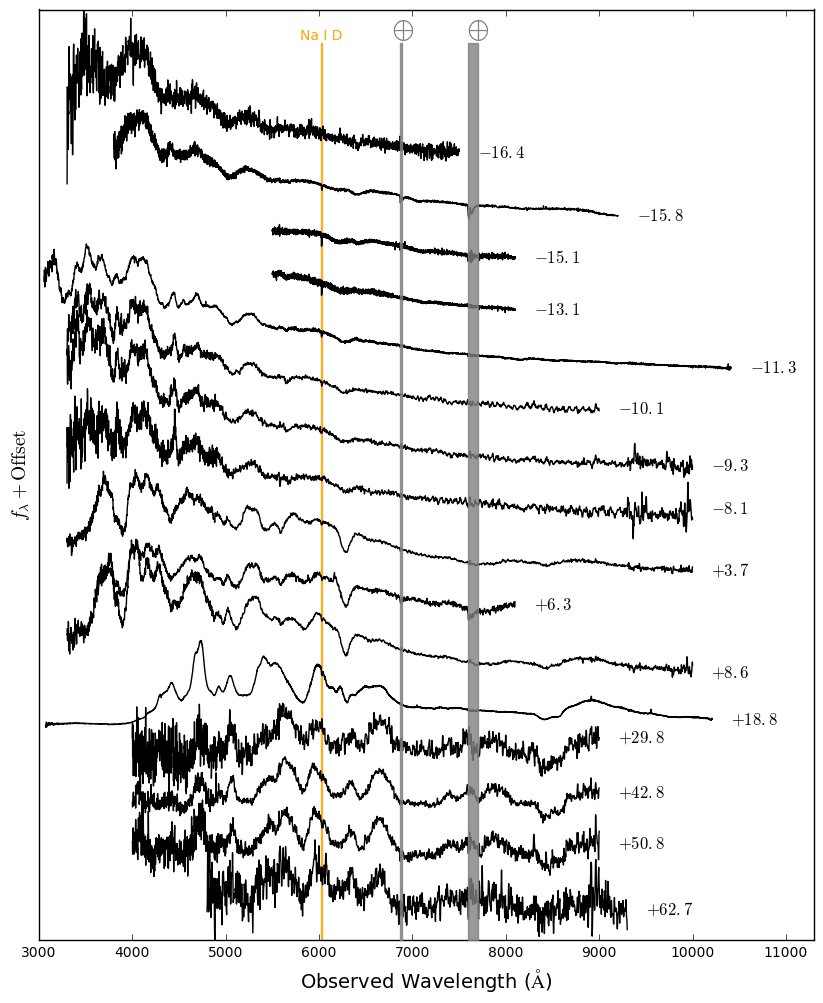

In [16]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(1, 1, 1)
offset = 0
for spec in spectra:
    if spec.telescope in ["P60", "VLT"]:
        continue
    phase = spec.MJD - T_MAX
    spec.plot(ax, offset=offset, color='k')
    ax.text(spec.data["wavelength"][-1] + 200,
            np.median(spec.data["flux"][-20:-1]) + offset, 
            "$%+5.1f$" % phase,
            fontsize=12,
            verticalalignment="center")
    offset += -1.5
ax.set_xlim(3000, 11300)
ax.set_ylim(-23, 5)

# telluric bands
y1, y2 = plt.ylim()
plt.fill_between(x=[7594, 7700], y1=y1, y2=y2 - 1, color='gray', alpha=0.8, zorder=9)
plt.fill_between(x=[6867, 6884], y1=y1, y2=y2 - 1, color='gray', alpha=0.8, zorder=9)
plt.text(6900, y2 - 1, "$\\bigoplus$", color="gray", verticalalignment="bottom", horizontalalignment="center")
plt.text(7700, y2 - 1, "$\\bigoplus$", color="gray", verticalalignment="bottom", horizontalalignment="center")

# Na I D
z = 0.0232
wv = 5890 * (1 + z)
plt.fill_between(x=[wv - 5, wv + 5], y1=y1, y2=y2 - 1, color='orange', alpha=0.8, zorder=1)
plt.text(wv, y2 - 1, "Na I D", color="orange", verticalalignment="bottom", horizontalalignment="center")

plt.xlabel("Observed Wavelength ($\\rm{\\AA}$)", fontsize=14)
plt.ylabel("$f_\\lambda + \\rm{Offset}$", fontsize=14)
plt.yticks([])
plt.savefig("spectra.pdf")

In [74]:
# prepare the observing log table
print """\
\\begin{deluxetable*}{cccccc}
  \\tablecaption{Spectroscopic observations of iPTF16abc \\label{tab:spec_obs_log}}
  \\tablehead{
    \\colhead{Observation MJD} & \\colhead{SN phase} & \\colhead{Telescope} &
    \\colhead{Instrument} & \\colhead{Wavelength Coverage (\\AA)}
  }
  \\startdata\
"""

for spec in spectra:
    print "    $%8.2f$ & $%+5.1f$ & %s & %s & $%i$--$%i$ \\\\" %\
        (spec.MJD, spec.MJD - T_MAX, spec.telescope, spec.instrument, 
         int(spec.data["wavelength"].min()),
         int(spec.data["wavelength"].max()))
        
print """\
  \\enddata
\\end{deluxetable*}\
"""

\begin{deluxetable*}{cccccc}
  \tablecaption{Spectroscopic observations of iPTF16abc \label{tab:spec_obs_log}}
  \tablehead{
    \colhead{Observation MJD} & \colhead{SN phase} & \colhead{Telescope} &
    \colhead{Instrument} & \colhead{Wavelength Coverage (\AA)}
  }
  \startdata
    $57483.26$ & $-16.4$ & DCT & DeVeny & $3301$--$7499$ \\
    $57483.88$ & $-15.8$ & Gemini-North & GMOS & $3800$--$9200$ \\
    $57484.51$ & $-15.1$ & Keck-II & DEIMOS & $5500$--$8099$ \\
    $57486.51$ & $-13.1$ & Keck-II & DEIMOS & $5500$--$8099$ \\
    $57488.38$ & $-11.3$ & Keck-I & LRIS & $3055$--$10411$ \\
    $57489.51$ & $-10.1$ & LCOGT-2m & FLOYDS & $3301$--$8999$ \\
    $57490.40$ & $ -9.3$ & LCOGT-2m & FLOYDS & $3301$--$9999$ \\
    $57491.55$ & $ -8.1$ & LCOGT-2m & FLOYDS & $3300$--$9998$ \\
    $57492.20$ & $ -7.5$ & VLT & X-shooter & $3300$--$24550$ \\
    $57494.00$ & $ -5.7$ & VLT & UVES & $4014$--$6039$ \\
    $57503.32$ & $ +3.7$ & LCOGT-2m & FLOYDS & $3300$--$9999$ \\
    $57506.00$ & $ +6

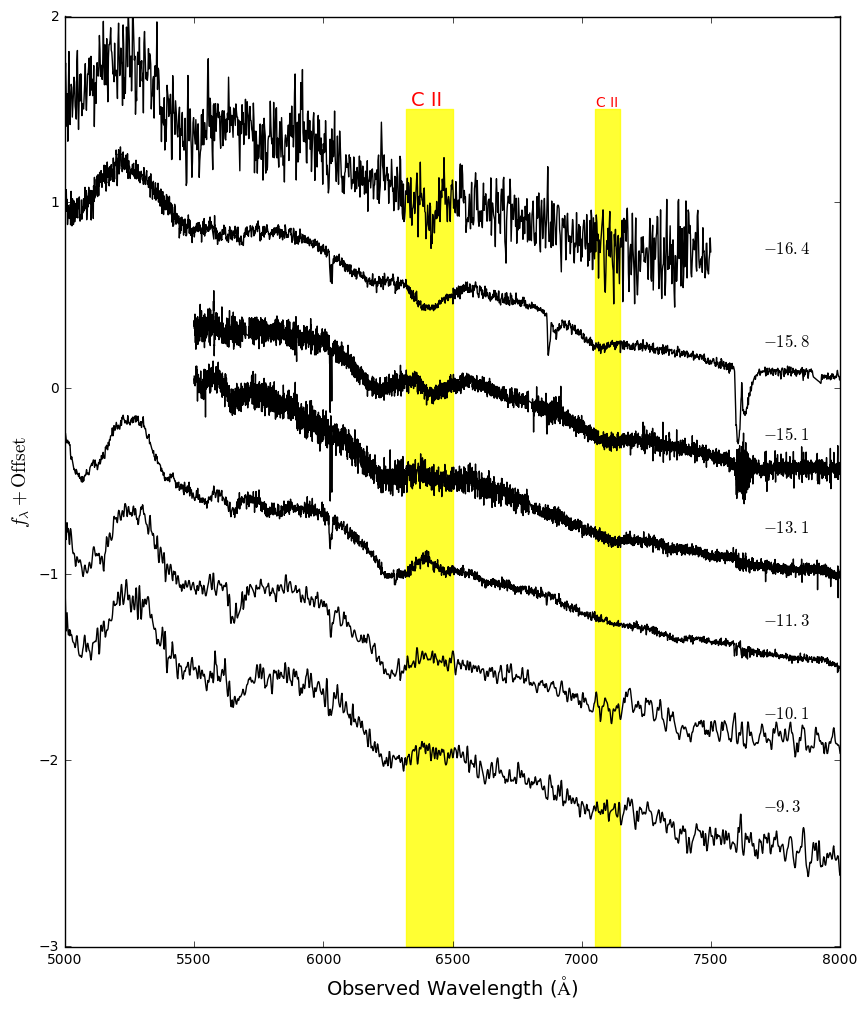

In [97]:
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(1, 1, 1)
offset = 0
for spec in spectra:
    if spec.telescope in ["P60", "VLT"]:
        continue
    if spec.MJD - T_MAX > -9:
        break
    phase = spec.MJD - T_MAX
    spec.plot(ax, offset=offset, color='k')
    ax.text(7700,
            0.75 + offset, 
            "$%+5.1f$" % phase,
            fontsize=12,
            verticalalignment="center")
    offset += -0.5
ax.set_xlim(5000, 8000)
ax.set_ylim(-3, 2)

# Carbon features
y1, y2 = plt.ylim()
plt.fill_between(x=[6320, 6500], y1=y1, y2=y2 - 0.5, color='yellow', alpha=0.8, zorder=1)
plt.fill_between(x=[7050, 7150], y1=y1, y2=y2 - 0.5, color='yellow', alpha=0.8, zorder=1)
plt.text(6400, y2 - 0.5, "C II", fontsize=14, color="red", verticalalignment="bottom", horizontalalignment="center")
plt.text(7100, y2 - 0.5, "C II", color="red", verticalalignment="bottom", horizontalalignment="center")

plt.xlabel("Observed Wavelength ($\\rm{\\AA}$)", fontsize=14)
plt.ylabel("$f_\\lambda + \\rm{Offset}$", fontsize=14)
plt.savefig("CarbonFeature.pdf")